# exp043

meta features

In [45]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp043"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.640 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [47]:
params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.01, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed, 
    'feature_pre_filter': False, 
    'lambda_l1': 4.134488140102331, 
    'lambda_l2': 0.007775200046481757, 
    'num_leaves': 75, 
    'feature_fraction': 0.5, 
    'bagging_fraction': 0.7036110805680353, 
    'bagging_freq': 3, 
    'min_data_in_leaf': 50, 
    'min_child_samples': 100
} 

In [48]:
features_used_total = [
    'record_cnt'
]

In [49]:
level_group_list = ['0-4', '5-12', '13-22']

event_name_list = [
    'cutscene_click', 'person_click', 'navigate_click',
    'observation_click', 'notification_click', 'object_click',
    'object_hover', 'map_hover', 'map_click', 'checkpoint',
    'notebook_click'
]

name_list = [
    'basic', 'undefined', 'close', 'open', 'prev', 'next'
]

page_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  

level_list = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22]

room_fqid_list = ['tunic.historicalsociety.closet',
 'tunic.historicalsociety.basement',
 'tunic.historicalsociety.entry',
 'tunic.historicalsociety.collection',
 'tunic.historicalsociety.stacks',
 'tunic.kohlcenter.halloffame',
 'tunic.capitol_0.hall',
 'tunic.historicalsociety.closet_dirty',
 'tunic.historicalsociety.frontdesk',
 'tunic.humanecology.frontdesk',
 'tunic.drycleaner.frontdesk',
 'tunic.library.frontdesk',
 'tunic.library.microfiche',
 'tunic.capitol_1.hall',
 'tunic.historicalsociety.cage',
 'tunic.historicalsociety.collection_flag',
 'tunic.wildlife.center',
 'tunic.flaghouse.entry',
 'tunic.capitol_2.hall']

In [50]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [51]:
class Features:
    def __init__(self, _sessions):
        self.sessions = _sessions.copy()
        self.features = self.sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _prep(self):
        self.sessions = self.sessions.sort_values(["session_id", "level_group", "elapsed_time"], ignore_index=True)
        self.sessions["elapsed_time_diff"] = self.sessions["elapsed_time"] - self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)

    def _record_cnt(self):
        """level_groupごとのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_record_cnt(self):
        """level_groupごと、各event_nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for event in event_name_list:
            new_col = f"{event}_record_cnt"
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _name_record_cnt(self):
        """level_groupごと、各nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for name in name_list:
            new_col = f"{name}_record_cnt"
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _page_record_cnt(self):
        """level_groupごと、各pageのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "page"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for page in page_list:
            new_col = f"page{str(int(page))}_cnt"
            tmp = add_features[add_features["page"]==page][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _room_fqid_record_cnt(self):
        """level_groupごと、各room_fqidのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "room_fqid"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for room in room_fqid_list:
            new_col = f"{room}_cnt"
            tmp = add_features[add_features["room_fqid"]==room][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _level_record_cnt(self):
        """各levelのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "level"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for level in level_list:
            new_col = f"level{str(int(level))}_cnt"
            tmp = add_features[add_features["level"]==level][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _elapsed_time(self):
        """level_groupごと、epapsed_timeのmax - min（経過時間）
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["elapsed_time"] = add_features["max"] - add_features["min"]
        add_features = add_features[["session_id", "level_group", "elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _coor_mean(self):
        """level_groupごと、座標系の平均値
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"room_coor_x_mean", "room_coor_y":"room_coor_y_mean", "screen_coor_x":"screen_coor_x_mean", "screen_coor_y":"screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_coor_mean(self):
        """level_groupごと、evemt_nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])[coor_cols].mean().reset_index()
        for event in event_name_list:
            if event in ['checkpoint', 'map_hover', 'object_hover']:
                # これらのデータには座標データが存在しないので特徴量化をスキップ
                continue
            col_map = {col:f"{event}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _name_coor_mean(self):
        """level_groupごと、nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])[coor_cols].mean().reset_index()
        for name in name_list:
            col_map = {col:f"{name}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["name"]==name].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _cat_col_nunique(self, col):
        """level_groupごと、[col]のユニーク数
        """
        add_features = self.sessions.dropna(subset=[col]).drop_duplicates(["session_id", "level_group", col])
        add_features = add_features.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":f"{col}_nunique"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _elapsed_time_diff_agg(self):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["elapsed_time_diff"].agg(["max", "min", "mean", "std"]).reset_index()
        add_features = add_features.rename(columns={"max":"elapsed_time_diff_max", "min":"elapsed_time_diff_min", "mean":"elapsed_time_diff_mean", "std":"elapsed_time_diff_std"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_elapsed_time_diff_agg(self, agg):
        """level_group、event_nameごとelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["elapsed_time_diff"].agg(agg).reset_index()
        for event in event_name_list:
            col_map = {a:f"{event}_elapsed_time_diff_{a}" for a in agg}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _room_fqid_elapsed_time_diff_agg(self, agg):
        """level_group、room_fqidごとelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "room_fqid"])["elapsed_time_diff"].agg(agg).reset_index()
        for room in room_fqid_list:
            col_map = {a:f"{room}_elapsed_time_diff_{a}" for a in agg}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["room_fqid"]==room].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["room_fqid"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1
                
    def _hover_duration_agg(self, agg):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        col_map = {a:f"hover_duration_{a}" for a in agg}
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["hover_duration"].agg(agg).reset_index()
        add_features = add_features.rename(columns=col_map)
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")


    def get_features(self):
        self._prep()
        self._record_cnt()
        self._event_name_record_cnt()
        self._name_record_cnt()
        self._elapsed_time()
        self._coor_mean()
        self._cat_col_nunique("text")
        self._elapsed_time_diff_agg()
        self._event_name_elapsed_time_diff_agg(["mean", "max", "min", "std"])
        self._event_name_coor_mean()
        self._name_coor_mean()
        self._page_record_cnt()
        self._hover_duration_agg(["mean", "max", "min", "std"])
        self._level_record_cnt()
        self._room_fqid_elapsed_time_diff_agg(["mean", "max", "min", "std"])
        self._room_fqid_record_cnt()
        return self.features

In [52]:
class History:
    def __init__(self):
        self.store = {}
        for c in features_used_total:
            self.store[c] = defaultdict(int)

    def record(self, train):
        df = train.drop_duplicates("session_id").set_index("session_id")[features_used_total]
        for session in df.index:
            for c in features_used_total:
                self.store[c][session] += df.at[session, c]

    def add_total_features(self, train):
        for c in features_used_total:
            train[f"total_{c}"] = train["session_id"].map(self.store[c])
        return train

In [53]:
def calc_metrics(oof):
    logloss = log_loss(oof["correct"], oof["pred"])

    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("logloss", format(logloss, ".6f"))
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_threshold

In [54]:
def get_train_data(sessions, labels, hist):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype("category")
    train["question"] = train["question"].astype("category")

    # level_groupの特徴量記録＆過去のgroup含めたtotal値の特徴量取得
    hist.record(train)
    train = hist.add_total_features(train)

    return train, hist

In [55]:
def prep_train_meta_features(oof):
    oof["level_group"] = oof["level_group"].astype(int)
    meta_df = oof.groupby(["session_id", "level_group"])["pred"].agg(["mean", "max", "min", "std"]).reset_index()
    meta_df = meta_df.rename(columns={"mean":"prev_group_pred_mean", "max":"prev_group_pred_max", "min":"prev_group_pred_min", "std":"prev_group_pred_std"})
    meta_df["level_group"] = meta_df["level_group"] + 1
    oof = oof.merge(meta_df, on=["session_id", "level_group"], how="left")
    oof = oof.drop(columns=["pred"])
    oof["level_group"] = oof["level_group"].astype("category")
    return oof

In [56]:
def run_train():
    dfs = []
    hist = History()
    for group in level_group_list:
        # データ読み込み
        train_sessions = pd.read_csv(cfg.prep_dir + f"train{group}.csv")
        labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")
        train_group, hist = get_train_data(train_sessions, labels, hist)
        dfs.append(train_group)
    train = pd.concat(dfs, ignore_index=True)
    # concatするとcategory型がリセットされてしまうので再度cast
    train["question"] = train["question"].astype("category")

    # 1st round (meta_features算出用)
    target = "correct"
    not_use_cols = [target, "session_id", "level_group"]
    features = [c for c in train.columns if c not in not_use_cols]
    gkf = GroupKFold(n_splits=cfg.n_splits)
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)
    oof_1st_round = pd.concat(oofs)
    oof_1st_round = oof_1st_round.reset_index(drop=True)

    # 2nd round
    train = prep_train_meta_features(oof_1st_round)
    not_use_cols = [target, "session_id", "level_group"]
    features = [c for c in train.columns if c not in not_use_cols]
    
    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        # モデル出力
        model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb")
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = model.feature_name()
        fi_fold["importance"] = model.feature_importance(importance_type="gain")
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof.to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip")

In [57]:
def get_mock_iter_test():
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [58]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
        
    models = []
    for i in range(cfg.n_splits):
        if mode == "local_cv":
            model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        elif mode == "kaggle_inf":
            model_path = f"/kaggle/input/jo-wilder-{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        models.append(lgb.Booster(model_file=model_path))
    
    prev_group_pred_mean = {}
    prev_group_pred_max = {}
    prev_group_pred_min = {}
    prev_group_pred_std = {}
    hist = History()
    for (sample_submission, test_sessions) in iter_test:

        level_group = test_sessions["level_group"].values[0]
        session_id = test_sessions["session_id"].values[0]

        test, hist = get_train_data(test_sessions, sample_submission, hist)

        # 一つ前のlevel_groupの予測値
        if level_group == "0-4":
            # 0-4は前の予測が存在しないのでnullを入れる
            test["prev_group_pred_mean"] = np.nan
            test["prev_group_pred_max"] = np.nan
            test["prev_group_pred_min"] = np.nan
            test["prev_group_pred_std"] = np.nan
        else:
            test["prev_group_pred_mean"] = prev_group_pred_mean[session_id]
            test["prev_group_pred_max"] = prev_group_pred_max[session_id]
            test["prev_group_pred_min"] = prev_group_pred_min[session_id]
            test["prev_group_pred_std"] = prev_group_pred_std[session_id]

        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            model = models[i]
            features = model.feature_name()
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits

        # 次のグループでの特徴量に使用するため結果を保存
        prev_group_pred_mean[session_id] = np.mean(preds)
        prev_group_pred_max[session_id] = np.max(preds)
        prev_group_pred_min[session_id] = np.min(preds)
        prev_group_pred_std[session_id] = np.std(preds)

        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)

fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119434, number of negative: 50180
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58130
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 259


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704152 -> initscore=0.867147
[LightGBM] [Info] Start training from score 0.867147
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.533013	valid_1's binary_logloss: 0.536683
[200]	training's binary_logloss: 0.502278	valid_1's binary_logloss: 0.509557
[300]	training's binary_logloss: 0.486357	valid_1's binary_logloss: 0.497724
[400]	training's binary_logloss: 0.476662	valid_1's binary_logloss: 0.492245
[500]	training's binary_logloss: 0.46954	valid_1's binary_logloss: 0.489441
[600]	training's binary_logloss: 0.46366	valid_1's binary_logloss: 0.488064
[700]	training's binary_logloss: 0.458377	valid_1's binary_logloss: 0.486973
[800]	training's binary_logloss: 0.453557	valid_1's binary_logloss: 0.486275
[900]	training's binary_logloss: 0.449115	valid_1's binary_logloss: 0

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119268, number of negative: 50346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58069
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 259
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703173 -> initscore=0.862454
[LightGBM] [Info] Start training from score 0.862454
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.53276	valid_1's binary_logloss: 0.53577
[200]	training's binary_logloss: 0.50149	valid_1's binary_logloss: 0.51033
[300]	training's binary_logloss: 0.485442	valid_1's binary_logloss: 0.499719
[400]	training's binary_logloss: 0.475596	valid_1's binary_logloss: 0.495037
[500]	training's binary_logloss: 0.468374	valid_1's binary_logloss: 0.492798
[600]	training's binary_logloss: 0.462505	valid_1's binary_logloss: 0.491784
[700]	training's binary_logloss: 0.457185	valid_1's binary_logloss: 0.490984
[800]	training's binary_logloss: 0.452402	valid_1's binary_logloss: 0.490509
[900]	training's binary_logloss: 0.447981	valid_1's binary_logloss: 0.490252
[1000]	training's binary_logloss: 0.443823	valid_1's binary_logloss: 0.489988
[1100]	training's binary_logloss: 0.439

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119502, number of negative: 50112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58196
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 259
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704553 -> initscore=0.869073
[LightGBM] [Info] Start training from score 0.869073
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.531322	valid_1's binary_logloss: 0.541862
[200]	training's binary_logloss: 0.50009	valid_1's binary_logloss: 0.515987
[300]	training's binary_logloss: 0.484178	valid_1's binary_logloss: 0.505017
[400]	training's binary_logloss: 0.47439	valid_1's binary_logloss: 0.499945
[500]	training's binary_logloss: 0.467184	valid_1's binary_logloss: 0.497436
[600]	training's binary_logloss: 0.46131	valid_1's binary_logloss: 0.496163
[700]	training's binary_logloss: 0.455999	valid_1's binary_logloss: 0.495166
[800]	training's binary_logloss: 0.451188	valid_1's binary_logloss: 0.494554
[900]	training's binary_logloss: 0.446759	valid_1's binary_logloss: 0.494153
[1000]	training's binary_logloss: 0.442559	valid_1's binary_logloss: 0.493916
[1100]	training's binary_logloss: 0.43

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119476, number of negative: 50138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58152
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 259
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704399 -> initscore=0.868336
[LightGBM] [Info] Start training from score 0.868336
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.532102	valid_1's binary_logloss: 0.539258
[200]	training's binary_logloss: 0.501104	valid_1's binary_logloss: 0.513016
[300]	training's binary_logloss: 0.485154	valid_1's binary_logloss: 0.50163
[400]	training's binary_logloss: 0.475315	valid_1's binary_logloss: 0.496487
[500]	training's binary_logloss: 0.468163	valid_1's binary_logloss: 0.494112
[600]	training's binary_logloss: 0.462247	valid_1's binary_logloss: 0.492949
[700]	training's binary_logloss: 0.456953	valid_1's binary_logloss: 0.492021
[800]	training's binary_logloss: 0.452155	valid_1's binary_logloss: 0.491534
[900]	training's binary_logloss: 0.44768	valid_1's binary_logloss: 0.491177
[1000]	training's binary_logloss: 0.443489	valid_1's binary_logloss: 0.490804
[1100]	training's binary_logloss: 0.4

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119328, number of negative: 50304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58114
[LightGBM] [Info] Number of data points in the train set: 169632, number of used features: 259
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703452 -> initscore=0.863791
[LightGBM] [Info] Start training from score 0.863791
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.532024	valid_1's binary_logloss: 0.538349
[200]	training's binary_logloss: 0.500941	valid_1's binary_logloss: 0.512974
[300]	training's binary_logloss: 0.485025	valid_1's binary_logloss: 0.502146
[400]	training's binary_logloss: 0.475294	valid_1's binary_logloss: 0.497185
[500]	training's binary_logloss: 0.468141	valid_1's binary_logloss: 0.494787
[600]	training's binary_logloss: 0.462331	valid_1's binary_logloss: 0.493647
[700]	training's binary_logloss: 0.457006	valid_1's binary_logloss: 0.492648
[800]	training's binary_logloss: 0.452237	valid_1's binary_logloss: 0.492014
[900]	training's binary_logloss: 0.4478	valid_1's binary_logloss: 0.491596
[1000]	training's binary_logloss: 0.443614	valid_1's binary_logloss: 0.491204
[1100]	training's binary_logloss: 0.439722	valid_1's binary_logloss: 0.49099
[1200]	training's binary_logloss: 0.435959	valid_1's binary_logloss: 0.490741
[1300]	training's binary_logloss: 0.432428	valid_1's binary_logloss: 0.49057

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119434, number of negative: 50180
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59150
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 263


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704152 -> initscore=0.867147
[LightGBM] [Info] Start training from score 0.867147
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.532158	valid_1's binary_logloss: 0.535035
[200]	training's binary_logloss: 0.503241	valid_1's binary_logloss: 0.509664
[300]	training's binary_logloss: 0.486279	valid_1's binary_logloss: 0.496534
[400]	training's binary_logloss: 0.47605	valid_1's binary_logloss: 0.490462
[500]	training's binary_logloss: 0.468487	valid_1's binary_logloss: 0.487103
[600]	training's binary_logloss: 0.462558	valid_1's binary_logloss: 0.485466
[700]	training's binary_logloss: 0.457342	valid_1's binary_logloss: 0.484434
[800]	training's binary_logloss: 0.452677	valid_1's binary_logloss: 0.483873
[900]	training's binary_logloss: 0.448248	valid_1's binary_logloss: 

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119268, number of negative: 50346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59089
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 263
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703173 -> initscore=0.862454
[LightGBM] [Info] Start training from score 0.862454
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.531872	valid_1's binary_logloss: 0.534614
[200]	training's binary_logloss: 0.502464	valid_1's binary_logloss: 0.510871
[300]	training's binary_logloss: 0.485283	valid_1's binary_logloss: 0.498988
[400]	training's binary_logloss: 0.474962	valid_1's binary_logloss: 0.49365
[500]	training's binary_logloss: 0.46735	valid_1's binary_logloss: 0.490867
[600]	training's binary_logloss: 0.46144	valid_1's binary_logloss: 0.489589
[700]	training's binary_logloss: 0.456204	valid_1's binary_logloss: 0.488825
[800]	training's binary_logloss: 0.45149	valid_1's binary_logloss: 0.488446
[900]	training's binary_logloss: 0.44705	valid_1's binary_logloss: 0.488177
[1000]	training's binary_logloss: 0.442889	valid_1's binary_logloss: 0.487957
[1100]	training's binary_logloss: 0.4389

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119502, number of negative: 50112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59216
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 263
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704553 -> initscore=0.869073
[LightGBM] [Info] Start training from score 0.869073
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.530214	valid_1's binary_logloss: 0.540687
[200]	training's binary_logloss: 0.500938	valid_1's binary_logloss: 0.517089
[300]	training's binary_logloss: 0.483795	valid_1's binary_logloss: 0.504845
[400]	training's binary_logloss: 0.473548	valid_1's binary_logloss: 0.499303
[500]	training's binary_logloss: 0.465995	valid_1's binary_logloss: 0.496302
[600]	training's binary_logloss: 0.460066	valid_1's binary_logloss: 0.494941
[700]	training's binary_logloss: 0.454842	valid_1's binary_logloss: 0.49401
[800]	training's binary_logloss: 0.45011	valid_1's binary_logloss: 0.49354
[900]	training's binary_logloss: 0.445715	valid_1's binary_logloss: 0.493131
[1000]	training's binary_logloss: 0.441558	valid_1's binary_logloss: 0.492758
[1100]	training's binary_logloss: 0.43

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119476, number of negative: 50138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59172
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 263


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704399 -> initscore=0.868336
[LightGBM] [Info] Start training from score 0.868336
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.530933	valid_1's binary_logloss: 0.538355
[200]	training's binary_logloss: 0.501723	valid_1's binary_logloss: 0.514231
[300]	training's binary_logloss: 0.484576	valid_1's binary_logloss: 0.501723
[400]	training's binary_logloss: 0.474301	valid_1's binary_logloss: 0.496171
[500]	training's binary_logloss: 0.466753	valid_1's binary_logloss: 0.493141
[600]	training's binary_logloss: 0.460819	valid_1's binary_logloss: 0.491843
[700]	training's binary_logloss: 0.455564	valid_1's binary_logloss: 0.491032
[800]	training's binary_logloss: 0.450818	valid_1's binary_logloss: 0.49061
[900]	training's binary_logloss: 0.446397	valid_1's binary_logloss: 

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119328, number of negative: 50304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59134
[LightGBM] [Info] Number of data points in the train set: 169632, number of used features: 263
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703452 -> initscore=0.863791
[LightGBM] [Info] Start training from score 0.863791
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.530892	valid_1's binary_logloss: 0.537736
[200]	training's binary_logloss: 0.501553	valid_1's binary_logloss: 0.514517
[300]	training's binary_logloss: 0.484412	valid_1's binary_logloss: 0.502355
[400]	training's binary_logloss: 0.474192	valid_1's binary_logloss: 0.496761
[500]	training's binary_logloss: 0.466717	valid_1's binary_logloss: 0.493748
[600]	training's binary_logloss: 0.460821	valid_1's binary_logloss: 0.49236
[700]	training's binary_logloss: 0.455651	valid_1's binary_logloss: 0.491595
[800]	training's binary_logloss: 0.450989	valid_1's binary_logloss: 0.491157
[900]	training's binary_logloss: 0.446604	valid_1's binary_logloss: 0.490777
[1000]	training's binary_logloss: 0.44244	valid_1's binary_logloss: 0.490551
[1100]	training's binary_logloss: 0.4

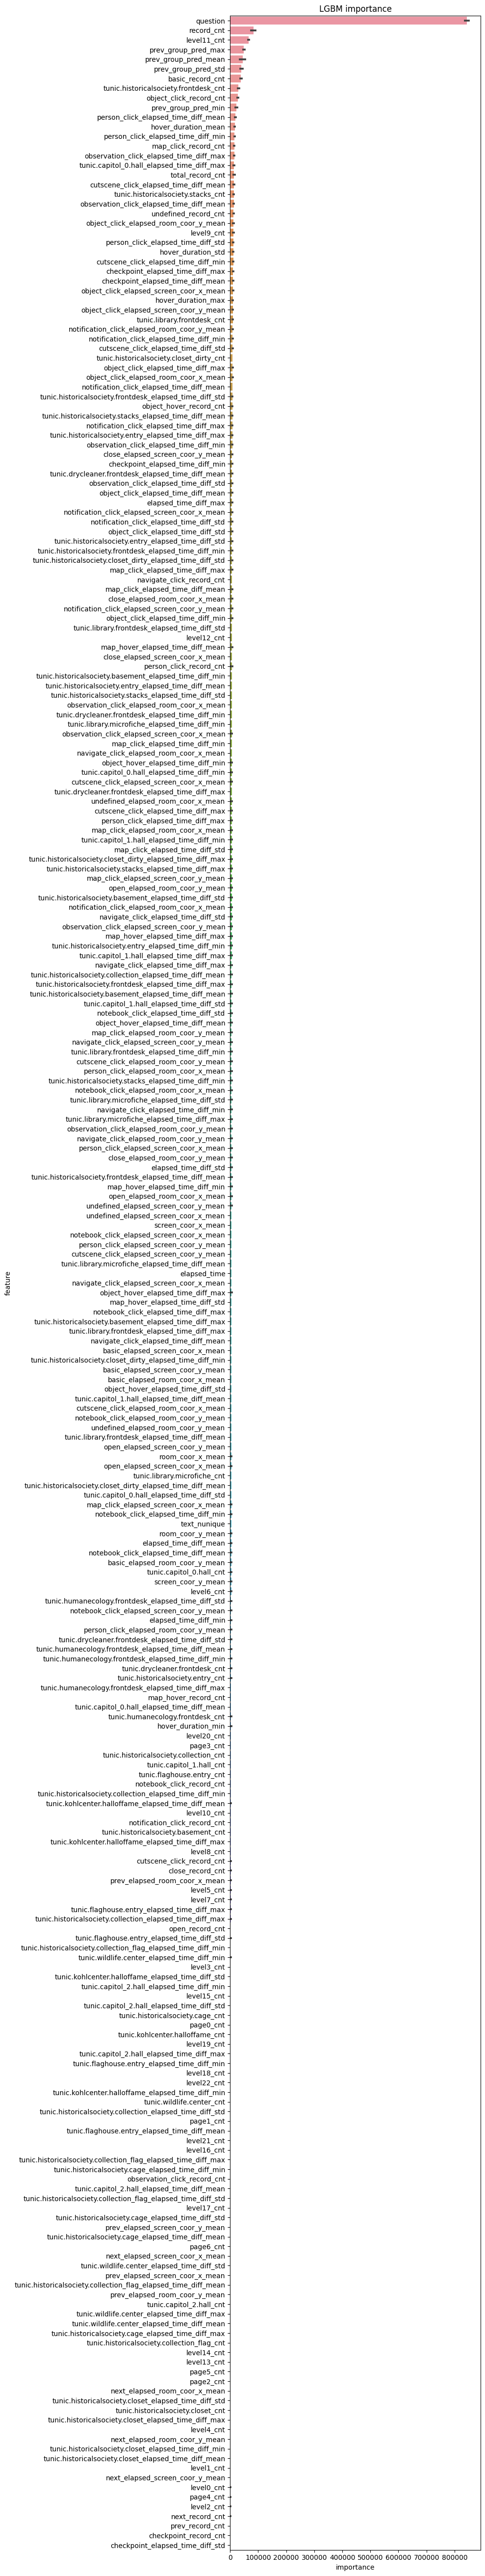

In [59]:
if cfg.mode == "local_cv":
    run_train()
inference(cfg.mode)